# HR202 RH Sensor

This script will analyze the sensor and model a circuit to extract its data.

This sensor needs AC current applied to it (for it not to be damaged), so that's why the slightly different "resistor divisor" layout

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import sympy as sp

# Voltage for power calculation
V = 3.0

vals = {0:  [np.NaN, np.NaN, 6.4e6, 2.9e6, 1.4e6, 700e3, 370e3, 190e3, 105e3, 62e3, 38e3  ,   23e3, 15.5e3, 10.5e3, 7.1e3],
        5:  [np.NaN, 10e6,   4.6e6, 2.1e6, 1.0e6, 500e3, 260e3, 140e3, 80e3,  48e3, 30e3  ,   18e3, 12e3  , 8.2e3 , 5.3e3],
        10: [np.NaN, 7e6,    3.2e6, 1.5e6, 750e3, 380e3, 200e3, 110e3, 62e3,  37e3, 24e3  ,   15e3, 10e3  , 6.8e3 , 4.7e3],
        15: [10e6,   5e6,    2.3e6, 1.1e6, 540e3, 280e3, 150e3, 84e3 , 50e3,  30e3, 19e3  ,   12e3, 8e3   , 5.5e3 , 4.0e3],
        20: [6.7e6,  3.4e6,  1.75e6,850e3, 420e3, 210e3, 115e3, 64e3 , 39e3,  24e3, 15.5e3,   10e3, 7e3   , 4.8e3 , 3.3e3],
        25: [5e6,    2.6e6,  1.3e6, 630e3, 310e3, 160e3, 87e3,  49e3 , 31e3,19.5e3, 13e3  ,  8.4e3, 5.7e3 , 4e3,    2.8e3],
        30: [3.9e6,  1.9e6,  970e3, 460e3, 235e3, 125e3, 69e3,  39e3 , 25e3,  16e3,10.5e3 ,  7.2e3, 5.0e3 , 3.5e3,  2.5e3], 35: [3.0e6,  1.5e6,  740e3, 380e3, 190e3, 100e3, 56e3,  33e3, 20e3,   13e3, 9e3   ,  6.2e3, 4.3e3 , 3.1e3,  2.2e3], 40: [2.4e6,  1.1e6,  570e3, 280e3, 140e3, 78e3,  45e3,  27e3,17.5e3,11.5e3, 8e3   ,  5.6e3, 3.9e3 , 2.8e3,  2e3  ],
        45: [1.75e6, 880e3,  420e3, 210e3, 110e3, 64e3,  38e3,  24e3, 15e3,   10e3, 7e3   ,  4.9e3, 3.4e3 , 2.4e3,  1.8e3]     
       } 
Rrh = pd.DataFrame(data=vals)

RH  = np.linspace(20, 90, 15)
RHs = np.arange(22.5, 90, 5)

# Fitting equation

Fitting equation to find B and then ideal resistor

$$ R_{HR202} = R_0\cdot exp(\frac{\beta}{RH} - \frac{\beta}{RH_0}) $$

(fitting not good)

[2.57355430e+05 9.43178846e+01 1.00000000e+00]


/home/patrick/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


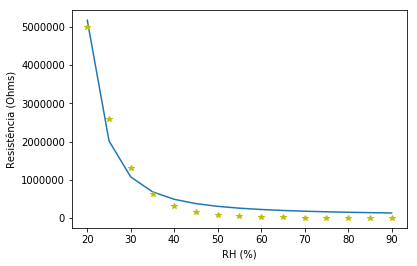

In [3]:
#Considering T=25 and RH = 50

# Exponential curve is based on this function:

x0 = 55

def func(x, a, b, c):
    return a * np.exp(b/x - b/x0)


# curve fitting
popt, pcov = curve_fit(func, RH, Rrh[25]) 

#Plot both
plt.plot(RH, func(RH, (*popt)))
plt.plot(RH, Rrh[25], 'y*')
plt.ylabel("Resistência (Ohms)")
plt.xlabel("RH (%)")

# Save parameters
B = popt[1]
RHc = 55

print(popt)

# Calculating ideal resistor value

To do that, we need to get the 2nd derivative of the function and make it equals zero.

(needs more work)

In [31]:
sp.init_printing(use_latex='mathjax')

# Declare symbols
R0 = sp.Symbol('R0')
B = sp.Symbol('B')
RHsy = sp.Symbol('RH')
Rs_s = sp.Symbol('Rs')

# R0 equation
Rrh_s = R0*sp.exp(B/RHsy - B/RHc)

#Rp_s = Rs_s*(Rrh_s)/(Rs_s+(Rrh_s))
Rp_s = (1/Rs_s + 1/Rrh_s)/(2/Rs_s + 1/Rrh_s)

# Get 2nd derivative
Rp_s2d = sp.simplify(sp.diff(Rp_s, RHsy, 2))

# Print 2nd derivative
print("Second derivative:\n")
sp.pprint(Rp_s2d)

# Get equation
Rs_ideal_s = Rp_s2d.subs([(R0, 2.57355e5), (RHsy, 55), (B, 94.3)])

# Equal Rs_ideal_s to zero and get Rs value
print("\nIdeal Rs value: {}".format(sp.solve(Rs_ideal_s, Rs_s)))

Second derivative:

         ⎛        B          B             B             B ⎞  B    B  
         ⎜        ──         ──            ──            ──⎟  ── + ── 
         ⎜        RH         55            RH            55⎟  55   RH 
 B⋅R₀⋅Rs⋅⎝2⋅B⋅R₀⋅ℯ   - B⋅Rs⋅ℯ   - 4⋅R₀⋅RH⋅ℯ   - 2⋅RH⋅Rs⋅ℯ  ⎠⋅ℯ        
──────────────────────────────────────────────────────────────────────
    ⎛       3⋅B              B    2⋅B             2⋅B   B         3⋅B⎞
    ⎜       ───              ── + ───             ─── + ──        ───⎟
  4 ⎜    3   RH        2     55    RH          2   55   RH     3   55⎟
RH ⋅⎝8⋅R₀ ⋅ℯ    + 12⋅R₀ ⋅Rs⋅ℯ         + 6⋅R₀⋅Rs ⋅ℯ         + Rs ⋅ℯ   ⎠

Ideal Rs value: [-39554.3171806169, 0.0]


# Plot
Plotting the output with the resistor divider. Vout is given by:

$$ Vout = Vcc\cdot\frac{ \frac{1}{R_s} + \frac{1}{R_{rh}} }{ \frac{2}{R_s} + \frac{1}{R_{rh}} } $$

<Figure size 720x720 with 0 Axes>

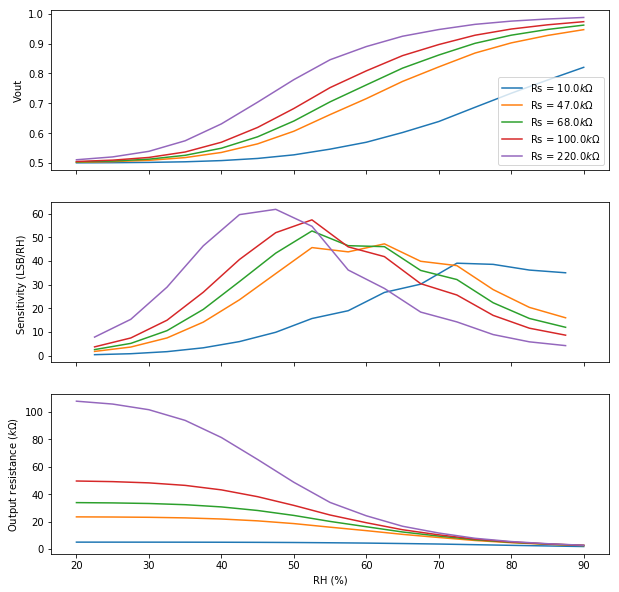

In [27]:
#df.plot()

list_Rs = [10e3, 47e3, 68e3, 100e3, 220e3];
list_temp = [0, 25, 40]

# temp at 25C

plt.rcParams['figure.figsize'] = [10, 10]
plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)

for Rs in list_Rs:
    temp = 25
    Reqbot= (2/Rs + 1/Rrh[temp])
    Reqtop = (1/Rs + 1/Rrh[temp])

    Vout = Reqtop/Reqbot
    Rout = 1/Reqbot
    
    S = np.diff(Vout)/5.0
    S = S*2**12

    ax1.plot(RH, Vout, label='Rs = {}$k\Omega$'.format(Rs/1000))
    ax1.set_ylabel('Vout')
    ax1.legend(loc="lower right")
    
    ax2.plot(RHs, S)
    ax2.set_ylabel('Sensitivity (LSB/RH) ')
    
    ax3.plot(RH, Rout/1000)
    ax3.set_ylabel('Output resistance ($k\Omega$)')
    
    ax3.set_xlabel('RH (%)')
    